# Cell 1: Install necessary libraries

In [ ]:
!pip install yfinance mplfinance

# Cell 2: Import libraries and define functions

In [ ]:
import pandas as pd
import yfinance as yf
import mplfinance as mpf

In [ ]:
# Download data
def download_data(ticker, start, end, interval='1d'):
    data = yf.download(ticker, interval=interval, start=start, end=end)
    data.columns = data.columns.droplevel('Ticker')  # Remove redundant column level
    data.reset_index(inplace=True)  # Reset index for easier handling
    data.columns.name = None  # Remove the column name 'Price'
    data.set_index('Date', inplace=True)
    return data

# Calculate signals and actions
def calculate_signals(data):
    data['ret'] = data['Close'].pct_change()
    data['SD'] = data['ret'].rolling(window=20).std()  # Rolling standard deviation
    data['2SD'] = data['ret'].rolling(window=20).mean() + 2 * data['SD']
    data['-2SD'] = data['ret'].rolling(window=20).mean() - 2 * data['SD']

    data['action'] = None
    data.loc[data['ret'] < data['-2SD'], 'action'] = 'buy'
    data.loc[data['ret'] > data['2SD'], 'action'] = 'sell'
    return data

# Identify paired trades
def identify_trades(data):
    valid_pairs = []
    current_position = None
    for index, row in data.iterrows():
        if row['action'] == 'buy' and current_position is None:
            current_position = {'buy_date': index, 'buy_price': row['Close']}
        elif row['action'] == 'sell' and current_position is not None:
            current_position['sell_date'] = index
            current_position['sell_price'] = row['Close']
            current_position['profit'] = current_position['sell_price'] - current_position['buy_price']
            valid_pairs.append(current_position)
            current_position = None
    return pd.DataFrame(valid_pairs)

# Analyze performance
def analyze_performance(paired_trades):
    win_trades = paired_trades[paired_trades['profit'] > 0]
    loss_trades = paired_trades[paired_trades['profit'] <= 0]
    win_rate = len(win_trades) / len(paired_trades) if len(paired_trades) > 0 else 0
    average_win = win_trades['profit'].mean() if len(win_trades) > 0 else 0
    average_loss = loss_trades['profit'].mean() if len(loss_trades) > 0 else 0
    rrr = average_win / abs(average_loss) if average_loss != 0 else None
    print(paired_trades[['buy_date', 'buy_price', 'sell_date', 'sell_price', 'profit']])
    print(f"Total Paired Trades: {len(paired_trades)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Win: {average_win:.2f}")
    print(f"Average Loss: {average_loss:.2f}")

# Cell 3: Set parameters and execute

In [ ]:
start = '2023-01-01'
end = '2025-01-01'
ticker = 'NVDA'  # You can change the ticker here

data = download_data(ticker, start, end)
data = calculate_signals(data)
paired_trades = identify_trades(data)
analyze_performance(paired_trades)

[*********************100%***********************]  1 of 1 completed

    buy_date   buy_price  sell_date  sell_price     profit
0 2023-08-02   44.248920 2023-08-14   43.733147  -0.515774
1 2023-10-17   43.921680 2024-01-08   52.238186   8.316505
2 2024-02-20   69.432312 2024-02-22   78.515747   9.083435
3 2024-04-19   76.181976 2024-05-23  103.774452  27.592476
4 2024-06-24  118.091759 2024-07-31  117.001923  -1.089836
Total Paired Trades: 5
Win Rate: 60.00%
Average Win: 15.00
Average Loss: -0.80


# Cell 4: Optional - Visualize with mplfinance

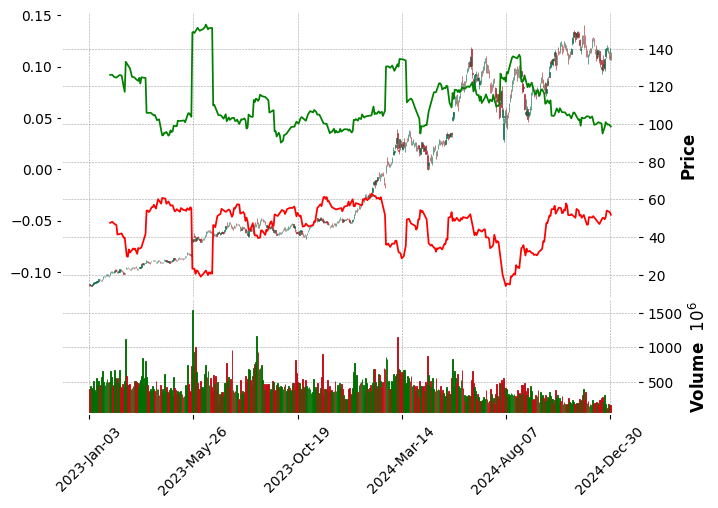

In [ ]:
mpf.plot(data, type='candle', volume=True, style='charles',
         addplot=[mpf.make_addplot(data['2SD'], color='g'),
                  mpf.make_addplot(data['-2SD'], color='r')])